# Example using feature extraction and Neural Networks
https://www.kaggle.com/afajohn/cnn-lstm-for-signal-classification-lb-0-513/notebook

In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq

from numba import jit
from tqdm import tqdm
import gc

import keras
import keras.backend as K
from keras.layers import LSTM,Dropout,Dense,TimeDistributed,Conv1D,MaxPooling1D,Flatten
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

from IPython.display import display, clear_output

from sklearn.metrics import matthews_corrcoef
from numpy.fft import *
from scipy import fftpack
from sklearn.model_selection import train_test_split

# import seaborn as sns
# sns.set_style("whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Feature Import

In [2]:
%%time
train = pq.read_pandas('data/train.parquet').to_pandas()

CPU times: user 41.5 s, sys: 1min 28s, total: 2min 9s
Wall time: 4min 7s


In [3]:
%%time
meta_train = pd.read_csv('data/metadata_train.csv')

CPU times: user 12 ms, sys: 16 ms, total: 28 ms
Wall time: 463 ms


## Feature Engineering
Here we are parsing each signal into 400 parts because 800,000 is too large for our LSTM dataset. The 'feature' is the range of voltage within each part. This results in a reduced dataset

In [4]:
@jit('float32(float32[:,:], int32)')
def feature_extractor(x, n_part=1000):
    length = len(x)
    pool = np.int32(np.ceil(length/n_part))
    output = np.zeros((n_part,))
    for j, i in enumerate(range(0,length, pool)):
        if i+pool < length:
            k = x[i:i+pool]
        else:
            k = x[i:]
        output[j] = np.max(k, axis=0) - np.min(k, axis=0)
    return output

In [5]:
x_train = []
y_train = []
for i in tqdm(meta_train.signal_id):
    idx = meta_train.loc[meta_train.signal_id==i, 'signal_id'].values.tolist()
    y_train.append(meta_train.loc[meta_train.signal_id==i, 'target'].values)
    x_train.append(abs(feature_extractor(train.iloc[:, idx].values, n_part=400)))

100%|██████████| 8712/8712 [03:51<00:00, 35.24it/s]


In [6]:
# del train; gc.collect()

In [7]:
y_train = np.array(y_train).reshape(-1,)

In [8]:
X_train = np.array(x_train).reshape(-1,x_train[0].shape[0])

## Build Primitive CNN + LSTM Model
CNN for feature extraction, LSTM for capturing time dependency

In [9]:
def keras_auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

## Import Test Data

In [10]:
%%time
test_set = pq.read_pandas('data/test.parquet').to_pandas()

CPU times: user 2min 14s, sys: 2min 37s, total: 4min 51s
Wall time: 9min 58s


In [11]:
%%time
meta_test = pd.read_csv('data/metadata_test.csv')

CPU times: user 8 ms, sys: 20 ms, total: 28 ms
Wall time: 271 ms


In [12]:
x_test = []
for i in tqdm(meta_test.signal_id.values):
   idx=i-8712
   clear_output(wait=True)
   x_test.append(abs(feature_extractor(test_set.iloc[:, idx].values, n_part=400)))

100%|██████████| 20337/20337 [09:41<00:00, 34.71it/s]


## Signal Feature Extraction

The next section parses each three phase system into individual high and low frequencies, and extracts the dc component of the system as a whole

In [13]:
def phase_indices(signal_num):
    phase1 = 3*signal_num
    phase2 = 3*signal_num + 1
    phase3 = 3*signal_num + 2
    return phase1,phase2,phase3

In [14]:
s_id = 1000
p1,p2,p3 = phase_indices(s_id)

In [15]:
p1

3000

In [16]:
#FFT to filter out HF components and get main signal profile
def low_pass(s, threshold=2e3):
    np.random.seed(1992)
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

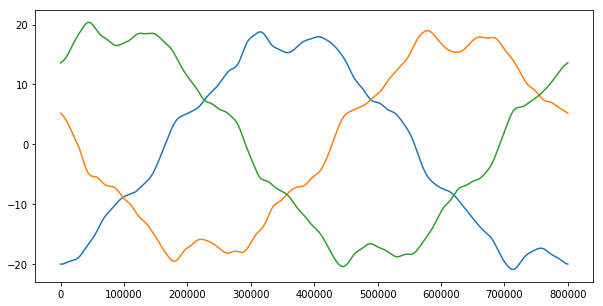

In [17]:
lf_signal_1 = low_pass(test_set.iloc[:,p1], 2000)
lf_signal_2 = low_pass(test_set.iloc[:,p2], 2000)
lf_signal_3 = low_pass(test_set.iloc[:,p3], 2000)
plt.figure(figsize=(10,5))
# plt.title('De-noised Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(lf_signal_1)
plt.plot(lf_signal_2)
plt.plot(lf_signal_3)

#### Filtering our High Frequency Components

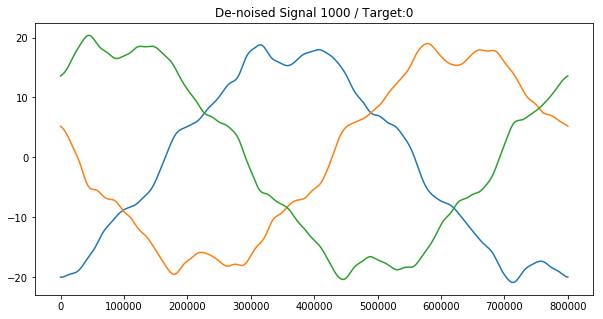

In [18]:
plt.figure(figsize=(10,5))
plt.title('De-noised Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(lf_signal_1)
plt.plot(lf_signal_2)
plt.plot(lf_signal_3)

In [19]:
lf_signal_1 = low_pass(train.iloc[:,p1], 2000)
lf_signal_2 = low_pass(train.iloc[:,p2], 2000)
lf_signal_3 = low_pass(train.iloc[:,p3], 2000)

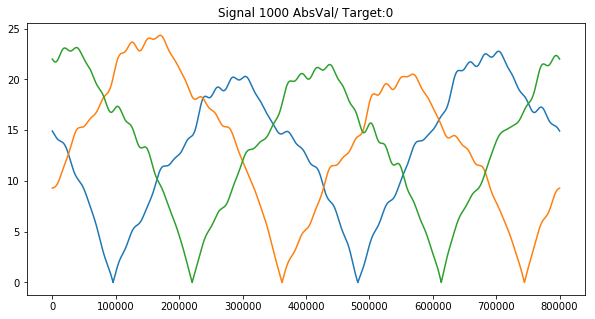

In [20]:
plt.figure(figsize=(10,5))
plt.title('Signal %d AbsVal/ Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(np.abs(lf_signal_1))
plt.plot(np.abs(lf_signal_2))
plt.plot(np.abs(lf_signal_3))

#### Get the DC component as the absolute value of the three phases

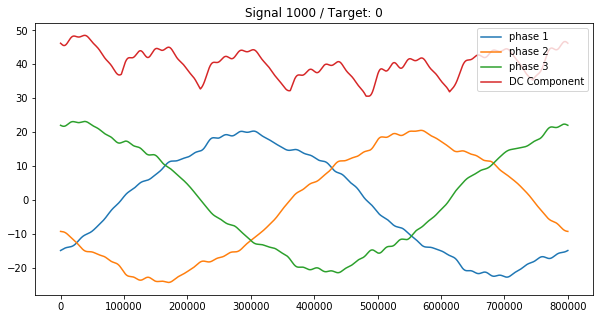

In [21]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target: %d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(lf_signal_1)
plt.plot(lf_signal_2)
plt.plot(lf_signal_3)
plt.plot((np.abs(lf_signal_1)+np.abs(lf_signal_2)+np.abs(lf_signal_3)))
plt.legend(['phase 1','phase 2','phase 3','DC Component'],loc=1)

#### Filtering out low frequency components

In [22]:
###Filter out low frequencies from the signal to get HF characteristics
def high_pass(s, threshold=1e7):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies < threshold] = 0
    return irfft(fourier)

In [23]:
hf_signal_1 = high_pass(train.iloc[:,p1])
hf_signal_2 = high_pass(train.iloc[:,p2])
hf_signal_3 = high_pass(train.iloc[:,p3])

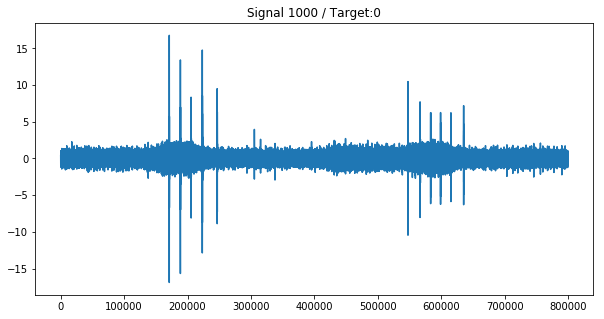

In [24]:
plt.figure(figsize=(10,5))
plt.title('Signal %d / Target:%d'%(s_id,meta_train[meta_train.id_measurement==s_id].target.unique()[0]))
plt.plot(hf_signal_1)
#plt.plot(hf_signal_2)
#plt.plot(hf_signal_3)

### Scale Signal Processing to entire training dataset

In [ ]:
x_train_lp = []
x_train_hp = []
x_train_dc = []
for i in meta_train.signal_id:    
    idx = meta_train.loc[meta_train.signal_id==i, 'signal_id'].values.tolist()
    clear_output(wait=True)
    display(idx)
    hp = high_pass(train.iloc[:, idx[0]])
    lp = low_pass(train.iloc[:, idx[0]])
    meas_id = meta_train.id_measurement[meta_train.signal_id==idx].values[0]
    p1,p2,p3=phase_indices(meas_id)
    lf_signal_1,lf_signal_2,lf_signal_3 = low_pass(train.iloc[:,p1]), low_pass(train.iloc[:,p2]), low_pass(train.iloc[:,p3])
    dc = np.abs(lf_signal_1)+np.abs(lf_signal_2)+np.abs(lf_signal_3)
    x_train_lp.append(abs(feature_extractor(lp, n_part=400)))
    x_train_hp.append(abs(feature_extractor(hp, n_part=400)))
    np.random.seed(1992) # this is key
    x_train_dc.append(abs(feature_extractor(dc, n_part=400)))

[6458]

In [ ]:
#check that DC component is same for each three-phase system
plt.figure(figsize=(10,5))

for i in range(1): # 6 total signals, 2 three-phase systems --> should only see two plots
    plt.plot(x_train_dc[i])

## Train Model:
* Stack the 4 components of analysis, then rerun CNN + LSTM architecture
* Split train dataset into train/test split (50/50)
* ReBuild the CNN + LSTM using all 4 components

In [ ]:
x_train2 = np.array(x_train).reshape(-1,x_train[0].shape[0])
x_train_lp2 = np.array(x_train_lp).reshape(-1,x_train_lp[0].shape[0])
x_train_hp2 = np.array(x_train_hp).reshape(-1,x_train_hp[0].shape[0])
x_train_dc2 = np.array(x_train_dc).reshape(-1,x_train_dc[0].shape[0])

In [ ]:
presplit_x = np.dstack((x_train2,x_train_lp2,x_train_hp2,x_train_dc2))
presplit_y = np.array(y_train).reshape(-1,)

### Train/Test Split for testing Purposes

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(presplit_x,
                                                       presplit_y,
                                                       test_size=0.33,
                                                       random_state=1992)

In [ ]:
# Have to reshape for the CNN to work on it
n_signals, n_steps, n_length = 4, 40, 10
X_train2 = X_train2.reshape((X_train2.shape[0], n_steps, n_length, n_signals))
X_train2.shape

In [ ]:
# Define CNN model, wrap in TimeDistributed to apply same layer to multiple time windows
np.random.seed(1992)
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_signals)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

# Add LSTM model
model.add(LSTM(100))
#model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras_auc])

In [ ]:
%%time
model.fit(X_train2, y_train2, epochs=20, batch_size=64, verbose=True)

Epoch 1/20


### Evaluate model using Matthew's Correlation Coefficient

In [ ]:
# Prep test data to run through model
X_test2 = X_test2.reshape((X_test2.shape[0], n_steps, n_length, n_signals))
X_test2.shape

In [ ]:
preds2 = model.predict(X_test2)
threshpreds2 = (preds2>0.5)*1
matthews_corrcoef(y_test2, threshpreds2)

## Hyperparameter Optimization

In [ ]:
def create_network(optimizer='adam'):
    
    np.random.seed(1992)
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_signals)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.2)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))

    # Add LSTM model
    model.add(LSTM(100))
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimzer, metrics=['accuracy'])
    
    # Return compiled network
    return network

In [ ]:
# Wrap Keras model so grid search cv can be applied
neural_network = KerasClassifier(build_fn=create_network, verbose=0)

In [ ]:
# Create hyperparameter space
epochs = [10,20,30,40,50,100]
batches = [5,10,50,100]
optimizers = ['adamax', 'adam']

# Create hyperparameter options
params = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)

In [ ]:
# Create grid search
grid = GridSearchCV(estimator=neural_network, param_grid=params, n_jobs=-1)

# Fit grid search
grid_result = grid.fit(X_test2, y_test2)

In [ ]:
# View hyperparameters of best neural network and use these to label the test data
grid_result.best_params_

## Label Test Data Set (Final Model)
first need to calculate 3 signal components for all data in test dataset

In [193]:
x_test_lp = []
x_test_hp = []
x_test_dc = []

for i in tqdm(meta_test.signal_id):
    idx = idx=i-8712
    clear_output(wait=True)
    display(idx)
    hp = high_pass(test_set.iloc[:, idx])
    lp = low_pass(test_set.iloc[:, idx])
    meas_id = meta_test.id_measurement[meta_test.signal_id==i].values[0]
    p1,p2,p3=phase_indices(meas_id)
    lf_signal_1,lf_signal_2,lf_signal_3 = low_pass(test_set.iloc[:,p1-8712]), low_pass(test_set.iloc[:,p2-8712]), low_pass(test_set.iloc[:,p3-8712])
    dc = np.abs(lf_signal_1)+np.abs(lf_signal_2)+np.abs(lf_signal_3)
    x_test_lp.append(abs(feature_extractor(lp, n_part=400)))
    x_test_hp.append(abs(feature_extractor(hp, n_part=400)))
    np.random.seed(1992) # this is key
    x_test_dc.append(abs(feature_extractor(dc, n_part=400)))

20336

100%|██████████| 20337/20337 [55:20<00:00,  6.81it/s]


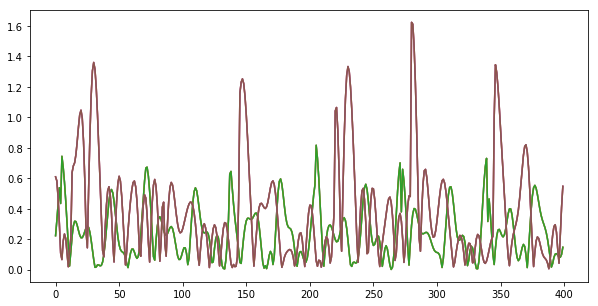

In [203]:
#check that DC component is same for each three-phase system
plt.figure(figsize=(10,5))

for i in range(6): # 6 total signals, 2 three-phase systems --> should only see two plots
    plt.plot(x_test_dc[i])

In [175]:
x_test2 = np.array(x_test).reshape(-1,x_test[0].shape[0])
x_test_lp2 = np.array(x_test_lp).reshape(-1,x_test_lp[0].shape[0])
x_test_hp2 = np.array(x_test_hp).reshape(-1,x_test_hp[0].shape[0])
x_test_dc2 = np.array(x_test_dc).reshape(-1,x_test_dc[0].shape[0])
test_final = np.dstack((x_test2,x_test_lp2,x_test_hp2,x_test_dc2))

In [176]:
# Have to reshape for the CNN to work on it
n_signals, n_steps, n_length = 4, 40, 10
train_final = presplit_x.reshape((presplit_x.shape[0], n_steps, n_length, n_signals))
train_final.shape

(8712, 40, 10, 4)

In [177]:
test_final2 = test_final.reshape((test_final.shape[0], n_steps, n_length, n_signals))
test_final2.shape

(20337, 40, 10, 4)

In [43]:
# Define CNN model_final, wrap in TimeDistributed to apply same layer to multiple time windows
np.random.seed(1992)
model_final = Sequential()
model_final.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_signals)))
model_final.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_final.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model_final.add(TimeDistributed(Dropout(0.2)))
model_final.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_final.add(TimeDistributed(Flatten()))

# Add LSTM model_final
model_final.add(LSTM(100))
model_final.add(Dense(100, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(1, activation='sigmoid'))

model_final.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras_auc])

In [44]:
%%time
model_final.fit(train_final, presplit_y, epochs=20, batch_size=64, verbose=True)

Epoch 1/20
8712/8712 [==============================] - 31s 4ms/step - loss: 0.1904 - keras_auc: 0.7021
Epoch 2/20
8712/8712 [==============================] - 25s 3ms/step - loss: 0.1462 - keras_auc: 0.8310
Epoch 3/20
8712/8712 [==============================] - 24s 3ms/step - loss: 0.1346 - keras_auc: 0.8721
Epoch 4/20
8712/8712 [==============================] - 22s 2ms/step - loss: 0.1293 - keras_auc: 0.8888
Epoch 5/20
8712/8712 [==============================] - 22s 2ms/step - loss: 0.1220 - keras_auc: 0.9013
Epoch 6/20
8712/8712 [==============================] - 21s 2ms/step - loss: 0.1184 - keras_auc: 0.9093
Epoch 7/20
8712/8712 [==============================] - 23s 3ms/step - loss: 0.1168 - keras_auc: 0.9153
Epoch 8/20
8712/8712 [==============================] - 24s 3ms/step - loss: 0.1137 - keras_auc: 0.9193
Epoch 9/20
8712/8712 [==============================] - 24s 3ms/step - loss: 0.1127 - keras_auc: 0.9236
Epoch 10/20
8712/8712 [==============================] - 24s 3ms

In [74]:
preds_final = model_final.predict(test_final2)
threshpreds_final = (preds_final>0.5)*1

In [75]:
sub = pd.read_csv('data/sample_submission.csv')
sub.target = threshpreds_final
sub.to_csv('data/predictions_3.csv',index=False)